In [1]:
import sys
import os.path as op
    
import numpy as np
import pandas as pd
import mne

module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_analysis.functions_preprocessing import split_raws

# Create path to the folder "behavioral"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"

# Create a list of path names that end with .csv
behav_path = op.join(behav_dir, "203.csv")#test


df = pd.read_csv(behav_path)


df.head()


Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first
0,203,blind,1,1,1,1,3.488252,0.075,1
1,203,blind,1,1,1,2,4.149057,0.075,1
2,203,blind,1,1,1,3,4.818118,0.075,1
3,203,blind,1,1,1,4,5.474000,0.075,1
4,203,blind,1,1,1,5,6.185978,0.075,1


In [2]:
def calculate_alpha(df):
    """
    Calculates the circular tapping synchrony measure as defined in Novembre et al. (2017).
    """

    # calculate the inter-person difference P(x) T(n) - P(y) T(n)
    # from both subjects' perspectives
    df = df.sort_values(['trial', 'tapnr'])
    df['diff_inter'] = df['ttap'].diff()
    df.iloc[::2, df.columns.get_loc('diff_inter')] = df['ttap'].diff(-1)

    # calculate the intra-person difference P(x) T(n + 1) - P(x) T(n)
    df['diff_intra'] = abs(df.groupby(['subject', 'trial'])['ttap'].diff(-1))  # .fillna(0)

    # calculate alpha and linearized alpha for all taps
    df['alpha'] = abs(df['diff_inter'] / df['diff_intra']) * 360
    df['alpha_lin'] = abs(180 - abs(df['alpha'] % 360 - 180))
    # TODO: discuss the linearization/ asynchronous trials. I found that there are single taps where the circular measure is larger than 360°
    # This means theoretically that the interperson diff is way bigger than the intra person diff, meaning that P1 made
    # the next tap already while P2 "misses" out one tap. By doing % 360, i define that these asynchronous trials are valid
    # and people can be synchronous, even if one tap was missed out by a person.
    # We could also instead remove these trials by removing the `% 360`, and cropping all df["alpha"] > 360 afterwards.
    
    return df


df = calculate_alpha(df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    ddd = df[["subject", "trial", "tapnr", "diff_intra", "diff_inter", "alpha", "alpha_lin"]]
    print(ddd.sort_index())

      subject  trial  tapnr  diff_intra  diff_inter        alpha   alpha_lin
0           1      1      1    0.660805    0.108922    59.339627   59.339627
1           1      1      2    0.669061    0.055085    29.639412   29.639412
2           1      1      3    0.655882    0.066063    36.260705   36.260705
3           1      1      4    0.711978    0.072040    36.425888   36.425888
4           1      1      5    0.664024    0.111816    60.620893   60.620893
5           1      1      6    0.657998    0.120869    66.129240   66.129240
6           1      1      7    0.715177    0.141863    71.409775   71.409775
7           1      1      8    0.631029    0.197791   112.839022  112.839022
8           1      1      9         NaN    0.153093          NaN         NaN
9           2      1      1    0.714642   -0.108922    54.869318   54.869318
10          2      1      2    0.658083   -0.055085    30.133860   30.133860
11          2      1      3    0.649905   -0.066063    36.594180   36.594180

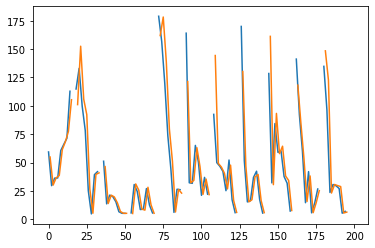

In [3]:

df.reset_index()["alpha_lin"].iloc[:200:2].plot()
df.reset_index()["alpha_lin"].iloc[1:200:2].plot()

In [4]:
def remove_outliers(df, exclude_stddev):
    """Remove all trials where the average alpha is `exclude_sttdev` sttdevs larger or
    smaller than the mean."""
    
    # calculate the mean alpha for each trial
    means = df.groupby(['trial'])["alpha"].mean()
    
    # define the upper and lower bounds, based on the mean and stddev of these means
    lower_bound = means.mean() - exclude_stddev * means.std()
    upper_bound = means.mean() + exclude_stddev * means.std()
    
    # filter the means so only the trials within the defined bounds remain
    good_trials = means[(lower_bound < means) & (means < upper_bound)]
    
    # return the df filtered for only the good trials
    return df[df["trial"].isin(good_trials.index)]


df = remove_outliers(df, 1)
df

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
0,203,blind,1,1,1,1,3.488252,0.075,1,0.108922,0.660805,59.339627,59.339627
9,203,blind,1,1,2,1,3.379330,0.075,1,-0.108922,0.714642,54.869318,54.869318
1,203,blind,1,1,1,2,4.149057,0.075,1,0.055085,0.669061,29.639412,29.639412
10,203,blind,1,1,2,2,4.093972,0.075,1,-0.055085,0.658083,30.133860,30.133860
2,203,blind,1,1,1,3,4.818118,0.075,1,0.066063,0.655882,36.260705,36.260705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5397,203,blind,12,300,2,7,6.136573,0.075,1,-0.038842,0.500590,27.933260,27.933260
5389,203,blind,12,300,1,8,6.621934,0.075,1,-0.015229,0.943700,5.809510,5.809510
5398,203,blind,12,300,2,8,6.637163,0.075,1,0.015229,0.467523,11.726555,11.726555
5390,203,blind,12,300,1,9,7.565634,0.075,1,0.460948,NaN,NaN,NaN


In [5]:
df[df.alpha > 360]

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
675,203,blind,2,38,2,1,4.363767,0.075,1,0.571847,0.550711,373.816799,13.816799
1143,203,blind,3,64,2,1,3.935732,0.050,2,0.486813,0.479382,365.580457,5.580457
2961,203,blind,7,165,2,1,3.769286,0.050,1,0.538839,0.511823,379.002311,19.002311
3231,203,blind,8,180,2,1,4.449860,0.075,1,0.518114,0.419937,444.164070,84.164070
3339,203,blind,8,186,2,1,3.973884,0.050,1,0.510733,0.448995,409.501168,49.501168
3411,203,blind,8,190,2,1,4.202482,0.100,2,0.507312,0.460877,396.271379,36.271379
3519,203,blind,8,196,2,1,4.330447,0.075,2,0.521973,0.468447,401.134298,41.134298
3555,203,blind,8,198,2,1,3.907565,0.075,2,0.492814,0.449021,395.110958,35.110958
3564,203,blind,8,199,1,1,3.465397,0.025,2,0.287795,0.287347,360.561258,0.561258
3717,203,blind,9,207,2,1,4.088723,0.100,2,0.508763,0.490071,373.731101,13.731101


In [6]:
subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'


pair = 202
participant = 0

# 1.2 define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(pair)
behav_path = op.join(behav_dir, str(pair) + ".csv")

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...


<ipython-input-6-2f01f4ed25ef>:13: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...


In [7]:
EVENT_DICT = {'s1/t1':6, 's1/t2':7, 's1/t3':8, 's1/t4':9, 's1/t5':10, 's1/t6':11, 's1/t7':12, 's1/t8':13, 's1/t9':14,
              's2/t1':15, 's2/t2':16, 's2/t3':17, 's2/t4':18, 's2/t5':19, 's2/t6':20, 's2/t7':21, 's2/t8':22, 's2/t9':23}

INV_EVENT_DICT = {str(val): key for key, val in EVENT_DICT.items()}


EVENT_DICT

{'s1/t1': 6,
 's1/t2': 7,
 's1/t3': 8,
 's1/t4': 9,
 's1/t5': 10,
 's1/t6': 11,
 's1/t7': 12,
 's1/t8': 13,
 's1/t9': 14,
 's2/t1': 15,
 's2/t2': 16,
 's2/t3': 17,
 's2/t4': 18,
 's2/t5': 19,
 's2/t6': 20,
 's2/t7': 21,
 's2/t8': 22,
 's2/t9': 23}

In [8]:
# 2.2. Look for events in raw
#raw.info

events = mne.find_events(combined_raw, shortest_event=1)
events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


array([[ 191183,       0,       1],
       [ 191252,       0,       2],
       [ 202497,       0,       2],
       ...,
       [5636326,       0,      23],
       [5636336,       0,      49],
       [5638973,       0,      46]])

In [9]:
def remove_ghost_triggers(df):
    """Removes Ghost Triggers from an event dataframe, based on the logic that
    all taps from each person should have a larger code than the previous tap
    from the same person."""
    
    # split the tap dataframe up for each subject
    for subj in [1,2]:
        subj_df = df[df['event_name'].str.startswith("s" + str(subj))]
        subj_df = subj_df.sort_values(['sample'])
    
    
        # look only at the indices and event codes from one person
        indices = subj_df["event_index"].to_numpy()
        event_codes = subj_df["event_code"].to_numpy()
    
        for i in range(len(indices)):
        
            # look at the previous code, current code and the current index
            previous_code = event_codes[i-1]
            current_code = event_codes[i]
            current_index = indices[i]
        
            # the initial tap codes are allowed to be smaller than the previous taps
            #if current_code not in (6, 15):
            # FIXME: The above logic leaves out ghost triggers with code 6 or 15. we must make sure these are also included.
            # i fix this in the below statement. However, this was not run in python, so if there are any errors, this might be the line to correct
            is_start_tap = ((current_code == 6) and (previous_code == 14)) or ((current_code == 15) and (previous_code == 23))
            if not is_start_tap:
            
                # for all other taps, if the code is not one step higher than the
                # previous trigger, it's a ghost trigger.
                if current_code != previous_code + 1:
                
                    # then we remove the ghost trigger from the orginial dataframe
                    df = df[df["event_index"] != current_index]
                    
                    # replace the ghost trigger value in event codes, so the next
                    # iteration will reference the last valid trigger.
                    event_codes[i] = event_codes[i-1]
                
    return df


In [10]:
def create_event_df(raw):
    """Reads events, assigns them event names and creates an event dataframe."""
    
    events = mne.find_events(raw, shortest_event=1)

    # create a pandas DataFrame to make working with events easier
    df_events = pd.DataFrame(events[:, (0, 2)])
    df_events.columns = ('sample','event_code')
    df_events['event_index'] = range(len(df_events))
    
    # add the trial number to later match the df with the behavioral data
    df_events['event_trial'] = 0
    
    # each time we see the "trial start" trigger, we increase the trial number
    for idx, row in df_events.iterrows():
        if row['event_code'] == 48:
            df_events['event_trial'][idx:] += 1

    # filter out the tapping events only
    df_events = df_events[df_events['event_code'].isin(EVENT_DICT.values())]

    # create a column including the event names
    df_events['event_name'] = [INV_EVENT_DICT[str(code)] for code in df_events['event_code']]
    
    return df_events


def events_from_event_df(df):
    """Sort a combined event dataframe and return it to a mne-style numpy array."""
    df = df.sort_values(['event_index'])
    events = np.vstack([df['sample'],
                        np.zeros(len(df)),
                        df['event_code']]).astype(int).T
    
    return events


def join_event_dfs(event_df, behavioral_df):
    """Join a behavioral and an event dataframe."""
    
    # sort both dataframes after trial, subject, tap
    event_df = event_df.sort_values(['event_trial', 'event_name'])
    behavioral_df = behavioral_df.sort_values(['trial', 'subject', 'tapnr'])
    
    # reset the event df index to the behavioral df
    event_df.index = behavioral_df.index
    
    return event_df.join(behavioral_df).drop(columns=['event_trial'])

In [11]:
event_df = create_event_df(combined_raw)
ghost_events = event_df['event_code'].value_counts()
ghost_events

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


20    301
23    300
19    300
12    300
16    300
9     300
13    300
17    300
21    300
6     300
10    300
14    300
18    300
22    300
7     300
11    300
15    300
8     300
Name: event_code, dtype: int64

In [12]:
event_df = create_event_df(combined_raw)
event_df = remove_ghost_triggers(event_df)
behavioral_df = calculate_alpha(pd.read_csv(behav_path))

joint_df = join_event_dfs(event_df, behavioral_df)

clean_df = remove_outliers(joint_df, exclude_stddev=2)

events = events_from_event_df(joint_df)

#print(events)
#clean_df.sort_index()

6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]


In [13]:
int(5635492 + (10.330310 - 9.516107) * 1024) # should be equal to 5636326

5636325

# Answer the questions from the "Behavioral Data" Document

In [14]:
all_subs = pd.DataFrame()

for subs in ['202','203','204','205','206','207','208','209','211','212']:
    behav_path = op.join(behav_dir, "{}.csv".format(subs))#test
    
    # calculate the alpha on all trials
    df = calculate_alpha(pd.read_csv(behav_path))
    
    # our filtering condition: take vp 1 for odd trials and vp 2 for even trials
    df = df[df["trial"]%2 != df["subject"] - 1]
    
    bad_trls = len(df[df["alpha"] > 360]["trial"].unique())
    per_a = bad_trls / df["trial"].max() * 100
    print("Pair {0} - Percent of incorrect trials: {1}%".format(subs, per_a))
    
    
    all_subs = all_subs.append(df)
    

all_subs["unique_trials"] = all_subs["pair"].astype(str) + "-" + all_subs["trial"].astype(str)
bad_trls = len(all_subs[all_subs["alpha"] > 360]["unique_trials"].unique())
per_a = bad_trls / len(all_subs["unique_trials"].unique()) * 100
print("All subs - Percent of incorrect trials: {0} %".format(per_a))

#print(all_subs["unique_trials"])

Pair 202 - Percent of incorrect trials: 6.0%
Pair 203 - Percent of incorrect trials: 9.333333333333334%
Pair 204 - Percent of incorrect trials: 11.333333333333332%
Pair 205 - Percent of incorrect trials: 3.3333333333333335%
Pair 206 - Percent of incorrect trials: 10.666666666666668%
Pair 207 - Percent of incorrect trials: 9.666666666666666%
Pair 208 - Percent of incorrect trials: 18.666666666666668%
Pair 209 - Percent of incorrect trials: 8.666666666666668%
Pair 211 - Percent of incorrect trials: 25.0%
Pair 212 - Percent of incorrect trials: 31.333333333333336%
All subs - Percent of incorrect trials: 13.4 %


In [15]:
# get all taps where one person tapped twice before the other person did
all_subs[all_subs["alpha"] > 360]

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin,unique_trials
148,202,blind,1,9,1,5,7.236328,0.075,1,-0.829144,0.810793,368.148058,8.148058,202-9
150,202,blind,1,9,1,7,8.932238,0.075,1,-0.872157,0.857896,365.984364,5.984364,202-9
151,202,blind,1,9,1,8,9.790134,0.075,1,-0.899273,0.809975,399.689234,39.689234,202-9
181,202,blind,1,11,1,2,4.665786,0.100,2,-1.208054,0.994704,437.214950,77.214950,202-11
351,202,blind,1,20,2,1,4.929792,0.050,1,1.256341,0.822949,549.587713,170.412287,202-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001,212,blind,12,278,2,7,6.272013,0.050,2,0.735059,0.360615,733.805408,13.805408,212-278
5002,212,blind,12,278,2,8,6.632628,0.050,2,0.741067,0.367277,726.384307,6.384307,212-278
5112,212,blind,12,285,1,1,4.217153,0.100,2,0.799759,0.414336,694.878836,25.121164,212-285
5220,212,blind,12,291,1,1,3.904741,0.100,2,0.623695,0.394126,569.691413,150.308587,212-291


In [16]:
# get all the trials that were affected by these double taps
len(all_subs[all_subs["alpha"] > 360]["trial"].unique())

231

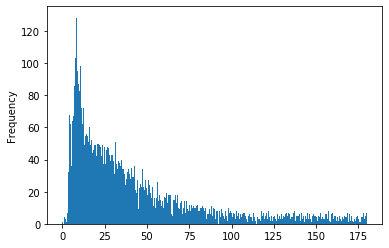

In [17]:
# get the distribution of valid alphas
all_subs[all_subs["alpha"] <= 360]["alpha_lin"].plot.hist(bins=len(all_subs)//20)

In [ ]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import os
import glob
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import expanduser

from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

######### APPLY DIRKS ALPHA & CLEANING ########

# Set defaults
data_path = "/Users/anne/github/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"
plots_path = './plots/'

# make folder for plots
os.makedirs(os.path.dirname(plots_path), exist_ok=True)

#interactive plots
#%matplotlib qt

# 1. Load and Prepare the data
# Create a list of path names that end with .csv
all_files = glob.glob(os.path.join(data_path, "*.csv"))

# 1.1 Concatenate all files to obtain a single dataframe
df_from_each_file = (pd.read_csv(f) for f in all_files)
df = pd.concat(df_from_each_file, ignore_index=True)

# create a list with all pairs
pair_list = list(df['pair'].unique())

# Eliminate Subjects with invalid datasets (from subj_list and from df)
pairs_with_invalid_data = [200, 210, 213, 214, 299]
pair_list = [item for item in pair_list if item not in pairs_with_invalid_data]
df = df[np.logical_not(df["pair"].isin(pairs_with_invalid_data))]

#eliminate not needed columns for a better overview
df.drop(['condition','player_start_first', 'jitter'], axis = 1, inplace = True)# Function to calculate alph from both subject's perspectives
'''
#TEST SORTING ALGORITHM
df_sorted = df[df.pair == 203].sort_values(by = ['trial', 'ttap'])
df_sorted[17:36]
df[df.pair == 203][17:36]
'''

def calculate_alpha(df):
    """
    Calculates the circular tapping synchrony measure as defined in Novembre et al. (2017).
    """

    # calculate the inter-person difference P(x) T(n) - P(y) T(n)
    # from both subjects' perspectives
    df = df.sort_values(['trial', 'tapnr'])
    df['ITI_inter'] = df['ttap'].diff()
    df.iloc[::2, df.columns.get_loc('ITI_inter')] = df['ttap'].diff(-1)

    # calculate the intra-person difference P(x) T(n + 1) - P(x) T(n)
    df['ITI_intra'] = abs(df.groupby(['subject', 'trial'])['ttap'].diff(-1))  # .fillna(0)

    # calculate alpha and linearized alpha for all taps
    df['alpha'] = abs(df['ITI_inter'] / df['ITI_intra']) * 360
    df['alpha_lin'] = abs(180 - abs(df['alpha'] - 180))
    # TODO: discuss the linearization/ asynchronous trials. I found that there are single taps where the circular measure is larger than 360°
    # This means theoretically that the interperson diff is way bigger than the intra person diff, meaning that P1 made
    # the next tap already while P2 "misses" out one tap. By doing % 360, i define that these asynchronous trials are valid
    # and people can be synchronous, even if one tap was missed out by a person.
    # We could also instead remove these trials by removing the `% 360`, and cropping all df["alpha"] > 360 afterwards.

    return df

# Create a new df with all synchronization measures (i.e. alpha & inter-/intra tap distances)
df_alpha = pd.DataFrame(columns=df.columns)

# Calculate alpha and ITI for all subs
for pair in pair_list:
    pairwise_df = df[df.pair == pair]
    df_alpha_pair = calculate_alpha(pairwise_df)
    df_alpha = pd.concat([df_alpha, df_alpha_pair])
    #sort tapping-times according to their temporal order
    pairwise_df = pairwise_df.sort_values(by = ['trial', 'ttap'])
df_alpha.reset_index(inplace = True, drop = True)

# Save time of first and last tap per trial in dataframe
first_tap = df_alpha.index - df_alpha.index[df_alpha.index%18]
df_alpha["first_tap"] = df_alpha["ttap"][first_tap].to_numpy()
last_tap = df_alpha.index - df_alpha.index[(df_alpha.index%18)] +17
df_alpha["last_tap"] = df_alpha["ttap"][last_tap].to_numpy()

# CLEAN DATA:
# Now, we should select the alpha-values according to the rule of Novembre et. al,
# i.e.  odd trials: alpha from sub1 perspective
#       even trials: alpha from sub2 perspective
df_alpha = df_alpha[df_alpha["trial"]%2 != df_alpha["subject"] - 1]

# FOR LATER PLOTS
bin_size = int(np.ceil(np.sqrt(len(df_alpha[df_alpha["alpha"] <= 360]["alpha_lin"]))))
#######

# Remove all trials where one person tapped twice before the other person did
lost_late_trials = df_alpha[df_alpha["alpha"] > 360][["pair","trial"]]
print("percentage of lost late trials after removing double taps:", round(len(lost_late_trials)/len(df_alpha)*100,2), "%")
df_alpha = df_alpha[df_alpha["alpha"] <= 360]
df_alpha.to_csv('cleaned_data.csv')

# Split data into early/late segments
# Select those alpha values that occur within the range of first tap + 1.5s and last tap - 1.5s (of each trial)
df_early = df_alpha[df_alpha["ttap"] <= df_alpha.first_tap+1.5 ][["pair","trial","alpha_lin"]]#["alpha_lin"]#.plot.hist(bins=bin_size)
df_early.reset_index(inplace = True, drop = True)
df_late = df_alpha[df_alpha["ttap"] >= df_alpha.last_tap-1.5 ][["pair","trial","alpha_lin"]]
df_late.reset_index(inplace = True, drop = True)

#["alpha_lin"]#.plot.hist(bins=bin_size)

# create (early/late) df with alpha-average per trial which can then be correlated with EEG early/late epochs
mean_alpha_early = df_early.groupby(['pair','trial']).alpha_lin.mean().reset_index()
mean_alpha_late = df_late.groupby(['pair','trial']).alpha_lin.mean().reset_index()
# merge both dataframes into one
mean_alpha = mean_alpha_early.merge(mean_alpha_late, on=["pair","trial"],suffixes=("_early","_late"))

# save all as csv
df_alpha.to_csv('df_alpha_temporal_order.csv')
df_early.to_csv('alpha_early.csv')
df_late.to_csv('alpha_late.csv')
mean_alpha.to_csv('mean_alpha.csv')

############ PLOTS ####################
from scipy import stats
# get the distribution of valid alphas

df_alpha["alpha_lin"].plot.hist(bins=bin_size)
plt.xlabel('Alpha (linearised) [degrees]')
plt.ylabel('Occurance')
plt.title('All valid alphas (alpha<360°)')
# create fig object
alpha_all = plt.gcf()
# save fig object
#pickle.dump(alpha_all, open(behav_plots + "alpha_all.p", 'wb'))

mean = np.around(np.mean(df_alpha["alpha_lin"]),decimals=2)
median = np.around(np.median(df_alpha["alpha_lin"]),decimals=2)
mode,xyz3 = stats.mode(np.around(df_alpha["alpha_lin"], decimals=3))

names = ["mode", "median", "mean"]
colors = ['red', 'blue', 'green']
measurements = [mode, median, mean]


for measurement, name, color in zip(measurements, names, colors):
    plt.vlines(x=measurement,ymin=0,ymax=1050, linestyle='--', linewidth=2.5,
                label='{0} at {1}'.format(name, measurement), colors=color)
plt.legend();
df_early["alpha_lin"].plot.hist(bins=bin_size)
df_late["alpha_lin"].plot.hist(bins=bin_size)

plt.suptitle('Early vs. late taps')
plt.legend(['First 1.5s','Last 1.5s'])
plt.xlabel('Alpha (linearised) [degrees]')
plt.ylabel('Occurance')

######### REMOVE OUTLIERS (not recommended due to huge lost of data) #######

def remove_outliers(df, exclude_stddev):
    """Remove all trials where the average alpha is `exclude_sttdev` sttdevs larger or
    smaller than the mean."""

    # calculate the mean alpha for each trial
    means = df.groupby(['trial'])["alpha"].mean()

    # define the upper and lower bounds, based on the mean and stddev of these means
    lower_bound = means.mean() - exclude_stddev * means.std()
    upper_bound = means.mean() + exclude_stddev * means.std()

    # filter the means so only the trials within the defined bounds remain
    good_trials = means[(lower_bound < means) & (means < upper_bound)]

    # return the df filtered for only the good trials
    return df[df["trial"].isin(good_trials.index)]


df_clean = remove_outliers(df, 1)
print("Percentage of lost data after removing outliers:",1-len(df_clean)/len(df))














######### MY ALPHA ########
path = os.getcwd() + '/data_analysis/Behavioural_Analysis'
# add functions script file path to sys path
sys.path.append(path)
from behavioural_analysis_functions import (get_alpha, clean_data)#, eliminate_ghost_triggers)
from functions_preprocessing_mne20 import \
    (split_raws, mark_bads, save_bads, run_ica, save_ica)

#%matplotlib qt

### Behavioural PART ####
# Load Behavioural Data (all pairs in one df with alpha values)
df = pd.read_csv("Behvaioural_Analysis_Data/Behavioural_Data_Alpha.csv", index_col=0)
# 2.1 Delete all rows with "None" (all tap #9)
#behvaioural_df_alpha = behvaioural_df_alpha.dropna()
df[df.pair==203]

def remove_outliers(df, exclude_stddev):
    """Remove all trials where the average alpha is `exclude_sttdev` sttdevs larger or
    smaller than the mean."""

    # calculate the mean alpha for each trial
    means = df.groupby(['trial'])["alpha"].mean()

    # define the upper and lower bounds, based on the mean and stddev of these means
    lower_bound = means.mean() - exclude_stddev * means.std()
    upper_bound = means.mean() + exclude_stddev * means.std()

    # filter the means so only the trials within the defined bounds remain
    good_trials = means[(lower_bound < means) & (means < upper_bound)]

    # return the df filtered for only the good trials
    return df[df["trial"].isin(good_trials.index)]


df_tmp = remove_outliers(df, 1)
amount_lost_data= (len(df)-len(df_tmp))/len(df_tmp)

df